# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system to detect whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

The ultimate objective is to prepare the model for deployment as part of an automated monitoring system. This system will enable real-time analysis of images and assist in ensuring compliance with workplace safety regulations.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
!pip install tensorflow -q


In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.18.0


In [3]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import SpatialDropout2D, GlobalAveragePooling2D
from tensorflow.keras.utils  import clear_session as cls

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')
pathl='/content/drive/MyDrive/Dataset/Labels_proj.csv'
pathim='/content/drive/MyDrive/Dataset/images_proj.npy'

Mounted at /content/drive


In [6]:
labels=pd.read_csv(pathl)
labels.head()

Label
0      1
1      1
2      1
3      1
4      1

In [7]:
images=np.load(pathim)
images.shape

(631, 200, 200, 3)

# **Exploratory Data Analysis**

###Plotting random images from each of the classes and printing their corresponding labels.

In [8]:
la1=labels[labels['Label']==1].index.tolist()
la0=labels[labels['Label']==0].index.tolist()
lam=la1[:4]+la0[:4]
lam


[0, 1, 2, 3, 271, 272, 273, 274]

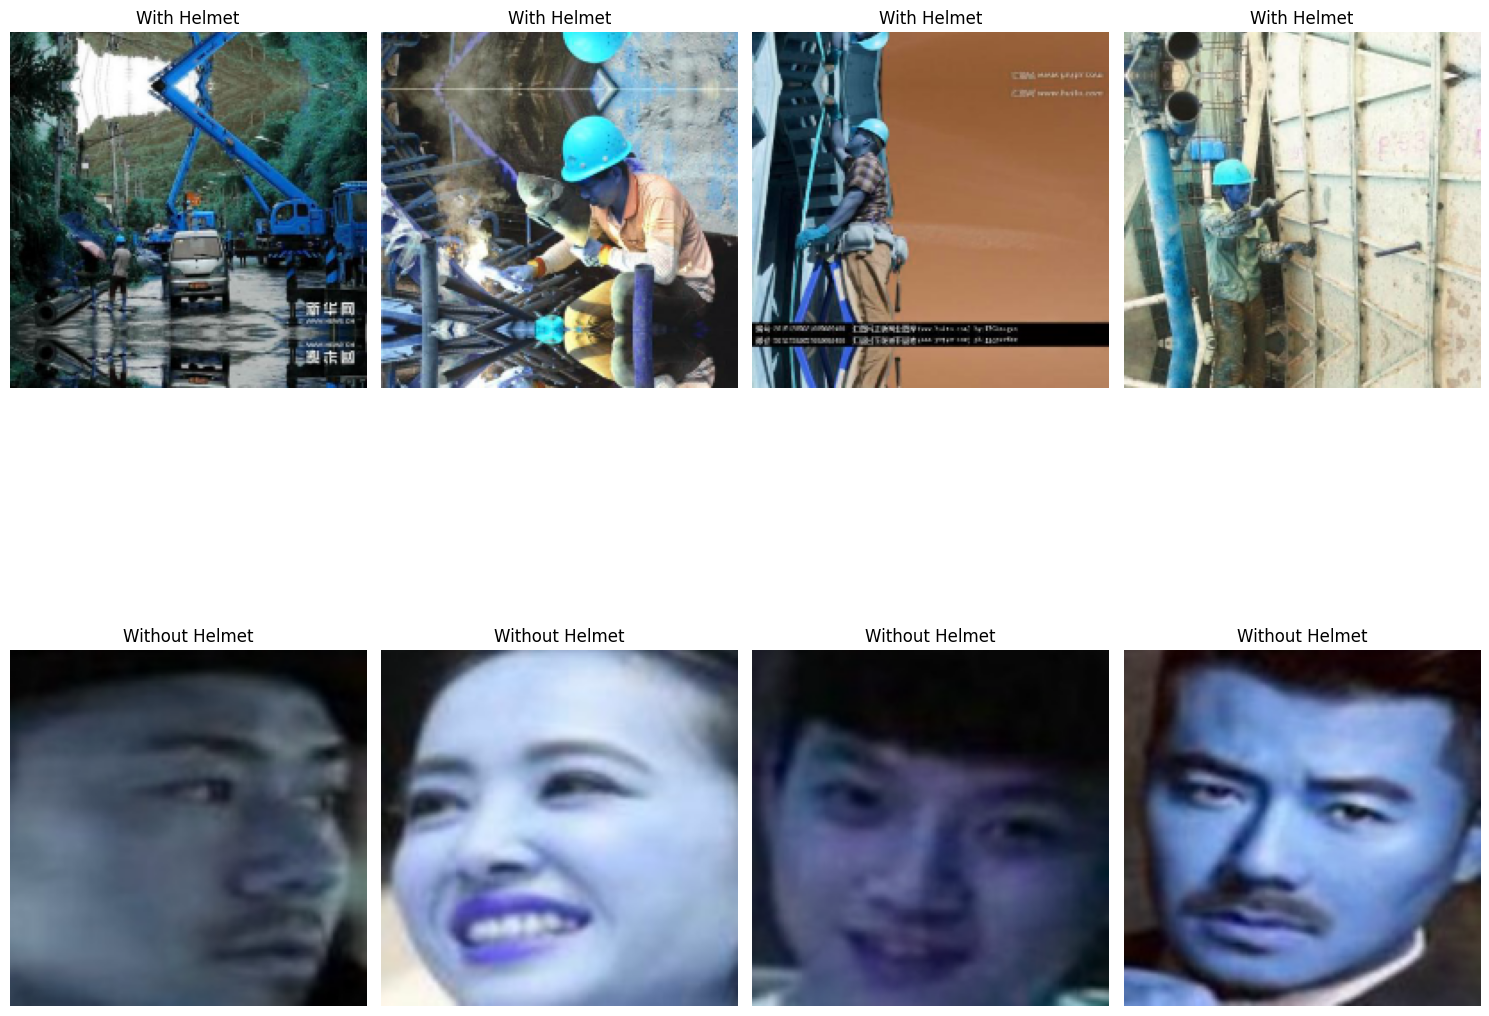

In [9]:
fig,ax=plt.subplots(2,4,figsize=(15,15))

ax=ax.flatten()
for i,j in zip(ax,lam):
  i.imshow(images[j])
  i.axis('off')
  if j in la1:
    i.set_title('With Helmet')
  else:
    i.set_title('Without Helmet')
plt.tight_layout()
plt.show()


### **Observations**
- From the images, we observe a blue tint, which occurs because matplotlib prints in RGB format, while the image might be in BGR format.


## Checking for class imbalance


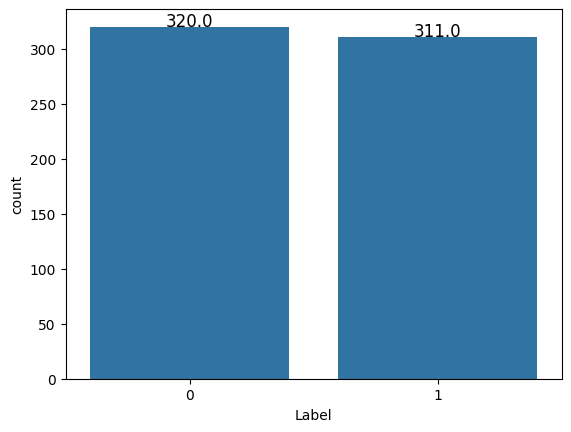

In [10]:
a=sns.countplot(data=labels,x='Label')
for i in a.patches:

    a.text(
        x=(i.get_x() + i.get_width() / 2),
        y=i.get_height() + 5,
        s=f"{i.get_height()}",
        ha='center',
        va='center',
        size=12
    )

# Show the plot
plt.show()

### **Observations:**
- The Class imbalance is not that very big to affect the performance of the model.

# **Data Preprocessing**

## Converting images to grayscale

In [11]:
imagegs=np.array([cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) for image in images])
imagegs=imagegs.reshape(631,200,200,1)
imagegs.shape

(631, 200, 200, 1)

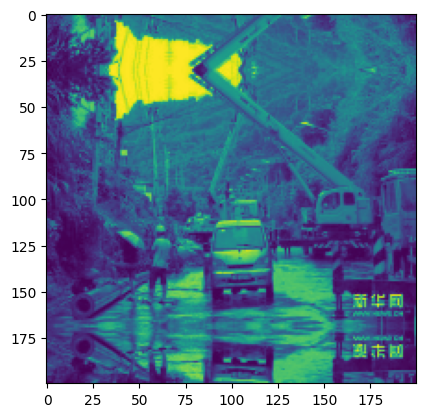

In [12]:
plt.imshow(imagegs[0])

### Splitting the dataset



In [13]:
x=imagegs
y=labels['Label']

In [14]:
x_train,x_temp,y_train,y_temp=train_test_split(x,y,test_size=0.4,stratify=y,random_state=812)

In [15]:
x_val,x_test,y_val,y_test=train_test_split(x_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=812)

In [16]:
x_val.shape,x_test.shape,x_train.shape

((126, 200, 200, 1), (127, 200, 200, 1), (378, 200, 200, 1))

In [17]:
y_val.value_counts(),y_test.value_counts(),y_train.value_counts()

(Label
 0    64
 1    62
 Name: count, dtype: int64,
 Label
 0    64
 1    63
 Name: count, dtype: int64,
 Label
 0    192
 1    186
 Name: count, dtype: int64)

### Data Normalization

In [18]:
x_train_normalized = x_train.astype('float32')/255.0
x_val_normalized = x_val.astype('float32')/255.0
x_test_normalized = x_test.astype('float32')/255.0

In [19]:
y_train[0]

np.int64(1)

### Data splitting & Normalisation for color data:
- Since VGG16 model works with three colour channels.

In [20]:
imagcol=np.array([cv2.cvtColor(image,cv2.COLOR_BGR2RGB) for image in images])
imagcol.shape

(631, 200, 200, 3)

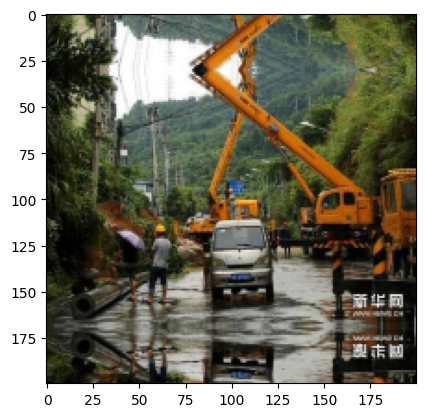

In [21]:
plt.imshow(imagcol[0])

In [22]:
xc=imagcol
yc=labels['Label']

In [23]:
xc_train,xc_temp,yc_train,yc_temp=train_test_split(xc,yc,test_size=0.4,stratify=y,random_state=812)

In [24]:
xc_val,xc_test,yc_val,yc_test=train_test_split(xc_temp,yc_temp,test_size=0.5,stratify=yc_temp,random_state=812)

In [25]:
xc_val.shape,xc_test.shape,xc_train.shape

((126, 200, 200, 3), (127, 200, 200, 3), (378, 200, 200, 3))

In [26]:
yc_val.value_counts(),yc_test.value_counts(),yc_train.value_counts()

(Label
 0    64
 1    62
 Name: count, dtype: int64,
 Label
 0    64
 1    63
 Name: count, dtype: int64,
 Label
 0    192
 1    186
 Name: count, dtype: int64)

In [27]:
xc_train_normalized = xc_train.astype('float32')/255.0
xc_val_normalized = xc_val.astype('float32')/255.0
xc_test_normalized = xc_test.astype('float32')/255.0

# **Model Building**

##**Model Evaluation Criterion**


The primary metric for evaluating the model will be **Recall** for the "Without Helmet" category.

#### **Reason for Choosing Recall:**
- **Critical Safety Focus:** Missing instances of workers not wearing helmets can result in severe safety risks. Prioritizing recall ensures that most non-compliant cases are detected, minimizing the risk of the workers getting injured.
- **Error Consequences:** False negatives (failing to detect a worker without a helmet) are more critical than false positives (incorrectly flagging a compliant worker), as undetected non-compliance could lead to accidents which could be even life threatening and also lead to legal issues.

#### **Secondary Metrics:**
- **Precision for "Without Helmet":** To avoid excessive false positives that could undermine system reliability.
- **F1 Score:** To balance recall and precision, ensuring an overall robust performance.
- **Accuracy:** For general performance evaluation.


## Utility Functions

In [28]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [29]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        xticklabels=["Without Helmet", "With Helmet"],
        yticklabels=["Without Helmet", "With Helmet"],
        ax=ax
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [30]:
# model for plotting loss
def plot_history(history):
  plt.figure(figsize=(15,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [31]:
cls()

In [32]:
m1=Sequential()
m1.add(Conv2D(64,(3,3),activation='relu',input_shape=(200,200,1),padding = 'same'))
m1.add(BatchNormalization())
m1.add(MaxPooling2D(2,2))

m1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
m1.add(BatchNormalization())
m1.add(MaxPooling2D(2,2))

m1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
m1.add(MaxPooling2D(2,2))
m1.add(Flatten())
m1.add(Dense(128,activation='relu'))
m1.add(BatchNormalization())
m1.add(Dropout(0.5))
m1.add(Dense(64,activation='relu'))
m1.add(BatchNormalization())
m1.add(Dropout(0.5))
m1.add(Dense(1,activation='sigmoid'))

In [33]:
m1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,953 (9.91 MB)

 Trainable params: 2,597,377 (9.91 MB)

 Non-trainable params: 576 (2.25 KB)

In [34]:
opti1=keras.optimizers.Adam(learning_rate=0.001)
m1.compile(optimizer=opti1,loss='binary_crossentropy',metrics=['accuracy'])

In [35]:
h1=m1.fit(x_train_normalized,y_train,epochs=32,validation_data=(x_val_normalized,y_val),batch_size=32)

Epoch 1/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 490ms/step - accuracy: 0.8082 - loss: 0.4418 - val_accuracy: 0.5397 - val_loss: 0.6556
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9675 - loss: 0.1107 - val_accuracy: 0.5079 - val_loss: 0.9194
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9595 - loss: 0.0820 - val_accuracy: 0.5079 - val_loss: 1.1182
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9917 - loss: 0.0410 - val_accuracy: 0.5079 - val_loss: 1.5547
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9807 - loss: 0.0375 - val_accuracy: 0.5079 - val_loss: 1.8322
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9959 - loss: 0.0281 - val_accuracy: 0.5079 - val_loss: 2.1043
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.5079 - val_loss: 2.3807
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.5079 -

In [36]:
m1tr=model_performance_classification(m1,x_train_normalized,y_train)
m1tr

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


Accuracy    Recall  Precision  F1 Score
0  0.579365  0.579365   0.769909  0.483952

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


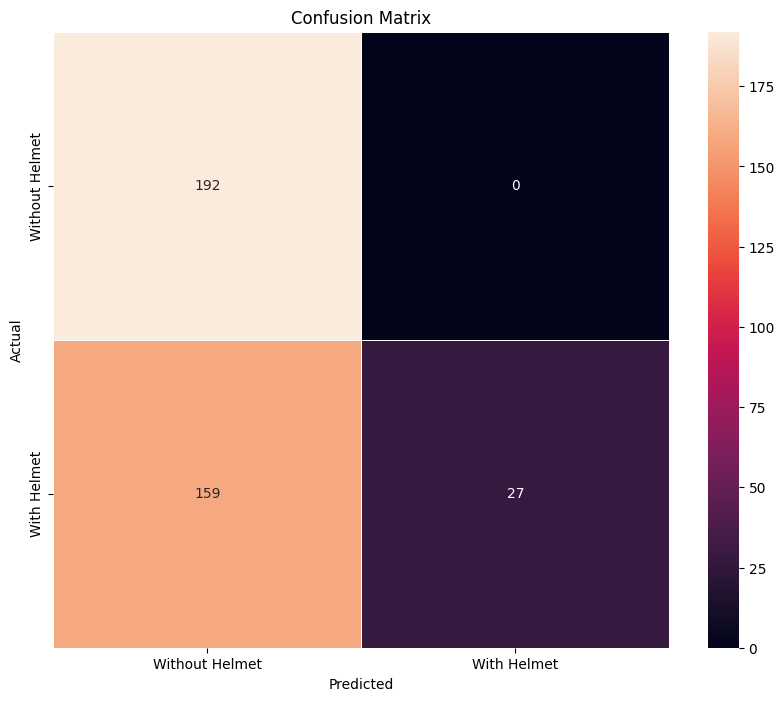

In [37]:
plot_confusion_matrix(m1,x_train_normalized,y_train)

In [38]:
m1vl=model_performance_classification(m1,x_val_normalized,y_val)
m1vl

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Accuracy    Recall  Precision  F1 Score
0  0.611111  0.611111   0.779744  0.537903

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


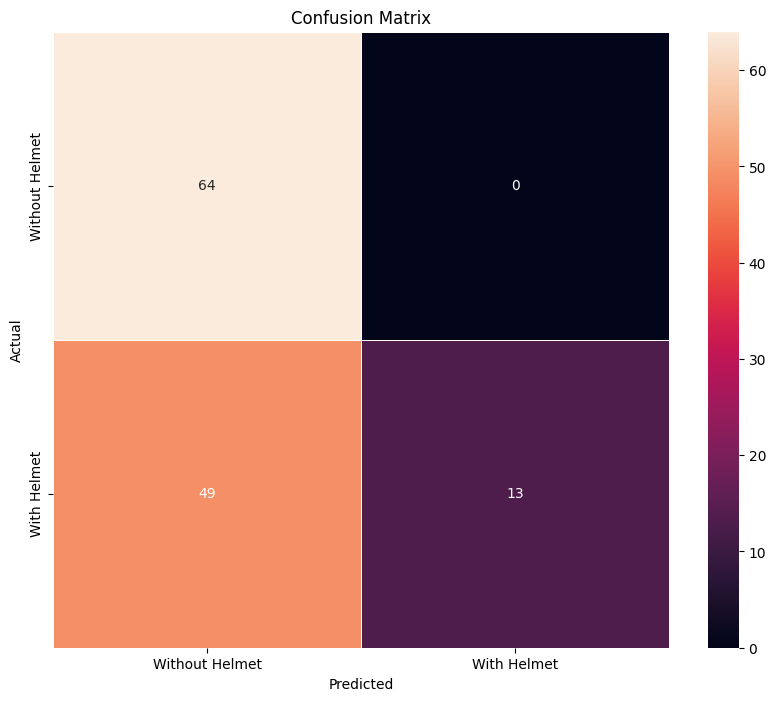

In [39]:
plot_confusion_matrix(m1,x_val_normalized,y_val)

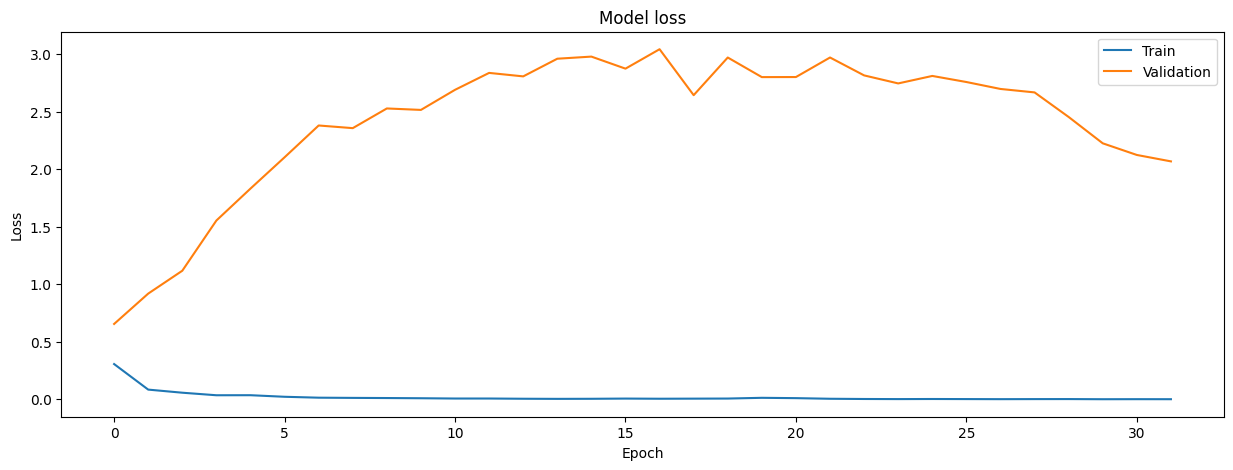

In [40]:
plot_history(h1)

### Vizualizing the predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


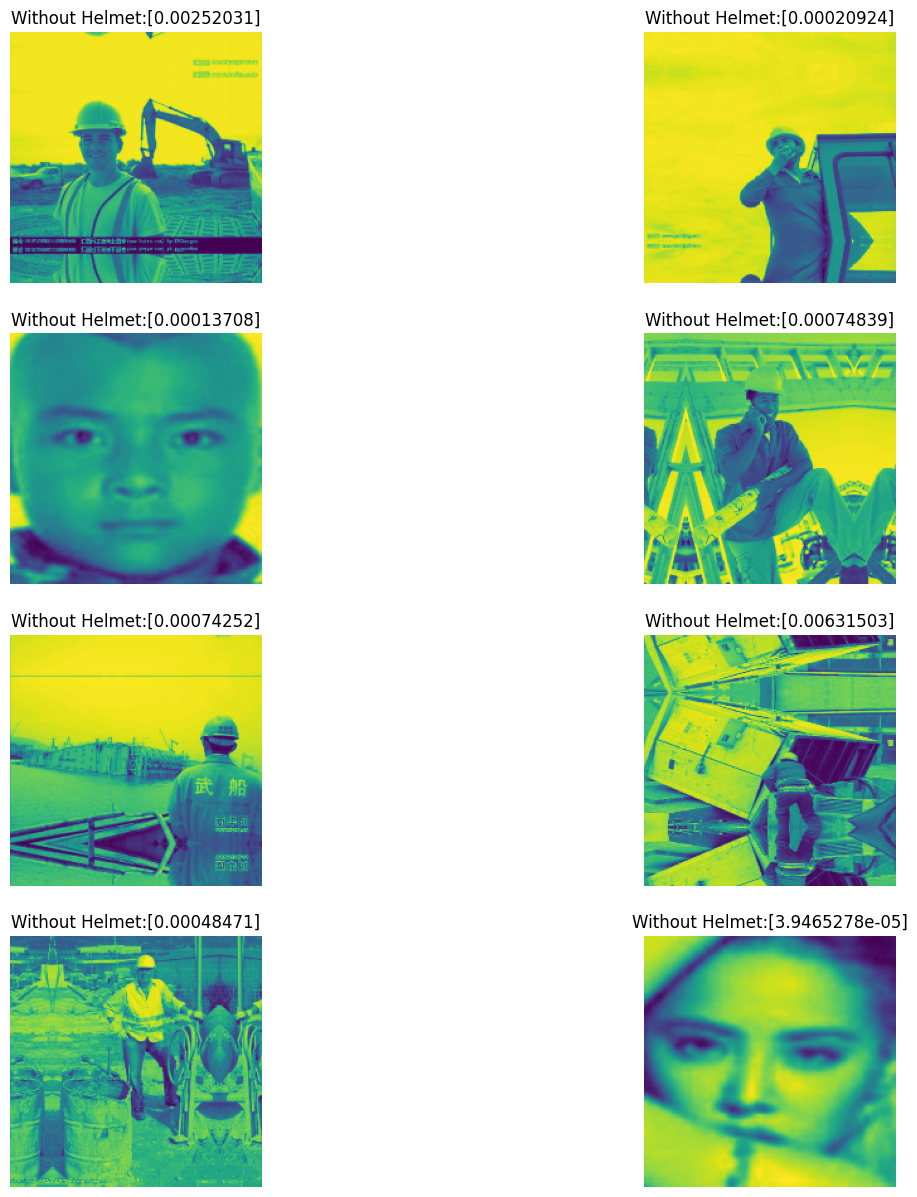

In [41]:
pre = m1.predict(x_train_normalized)
f,ax=plt.subplots(4,2,figsize=(15,15))
for i,j in zip(ax.flatten(),range(8)):
  i.imshow(x_train[j])
  i.axis('off')
  if pre[j]>0.5:
    i.set_title(f'With Helmet:{pre[j]}')
  else:
    i.set_title(f'Without Helmet:{pre[j]}')


### **Observations on model 1:**
- As we observe the metrics evaluations and confusion matrix we can clearly see that recall is very low and metrics are not upto mark.
- The FN are fairly high with low recalls which means the model is not able to distinguish peolple `With Helmets` as FP  are zero.
- The model is not able to classify even with grayscale image which has reduced dimensions.
- Heavy validation losses also shows that the model struggles to distinguish between people `With Helmets` and those Without Helmets, as this indicates the model had not learned the distinguishing features effectively.

## Model 2: (VGG-16 (Base))

In [42]:
vgg16_m=VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [43]:
for layers in vgg16_m.layers:
  layers.trainable=False

In [44]:
for layers in vgg16_m.layers:
  print(layers.name,layers.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [45]:
vgg16_m.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
cls()

In [47]:
m2=Sequential()
m2.add(vgg16_m)
m2.add(Flatten())

m2.add(Dense(1, activation='sigmoid'))

In [48]:
opti2=keras.optimizers.Adam(learning_rate=0.001)
m2.compile(optimizer=opti2,loss='binary_crossentropy',metrics=['accuracy'])

In [49]:
h2=m2.fit(xc_train_normalized,yc_train,epochs=32,validation_data=(xc_val_normalized,yc_val),batch_size=32)

Epoch 1/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.7551 - loss: 0.4722 - val_accuracy: 0.9841 - val_loss: 0.0370
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 0.9841 - val_loss: 0.0183
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - 

In [50]:
m2tr=model_performance_classification(m2,xc_train_normalized,yc_train)
m2tr

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


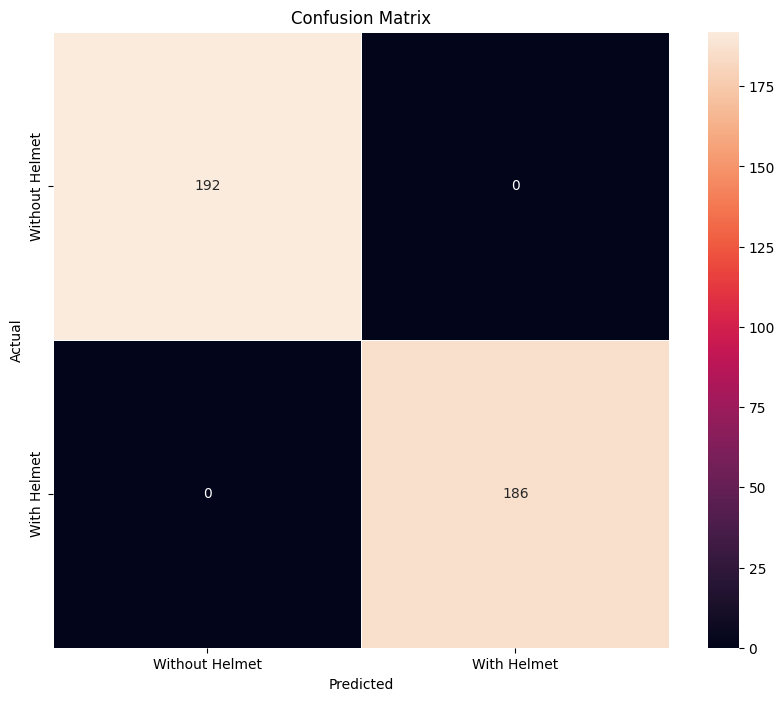

In [51]:
plot_confusion_matrix(m2,xc_train_normalized,yc_train)

In [52]:
m2vl=model_performance_classification(m2,xc_val_normalized,yc_val)
m2vl

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


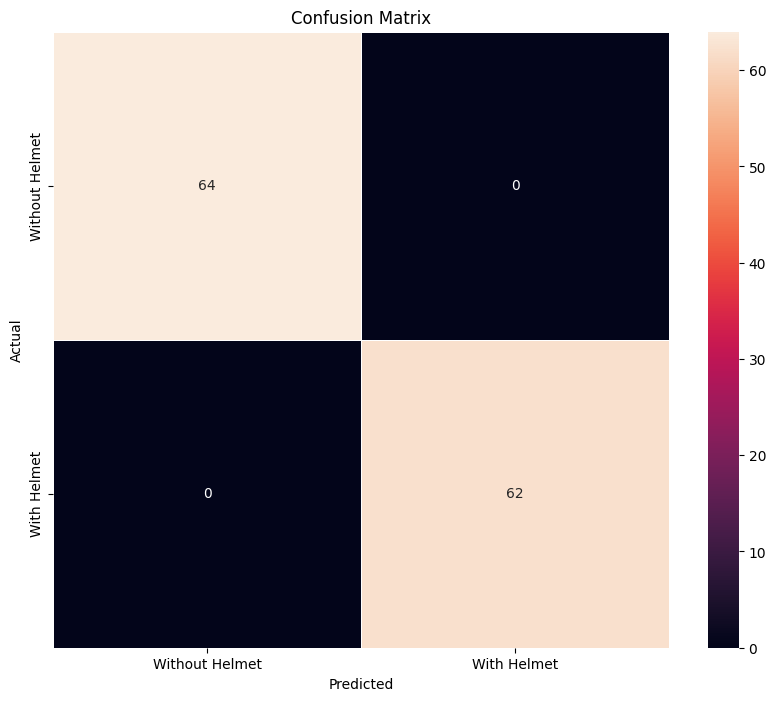

In [53]:
plot_confusion_matrix(m2,xc_val_normalized,yc_val)

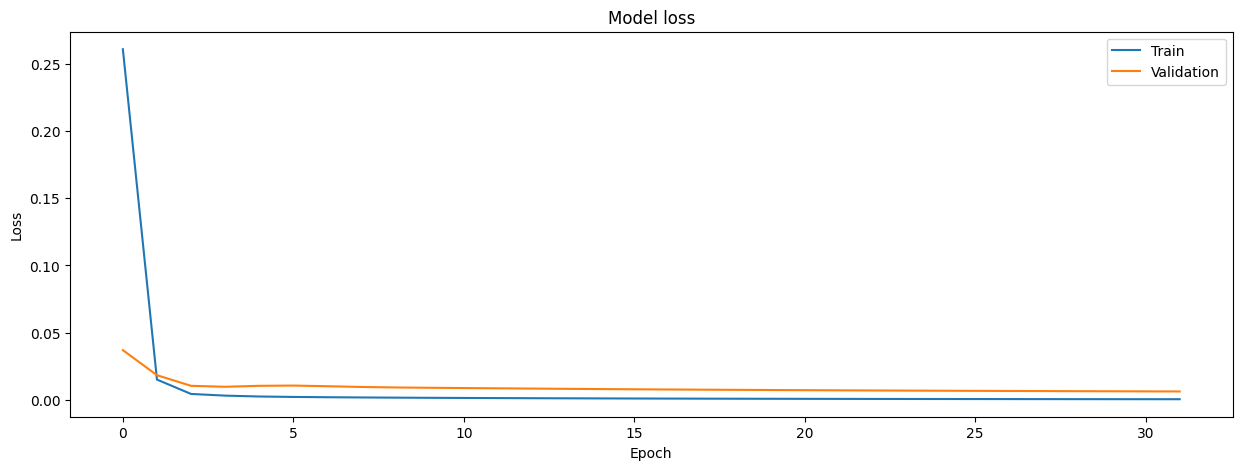

In [54]:
plot_history(h2)

### Visualizing the prediction:

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


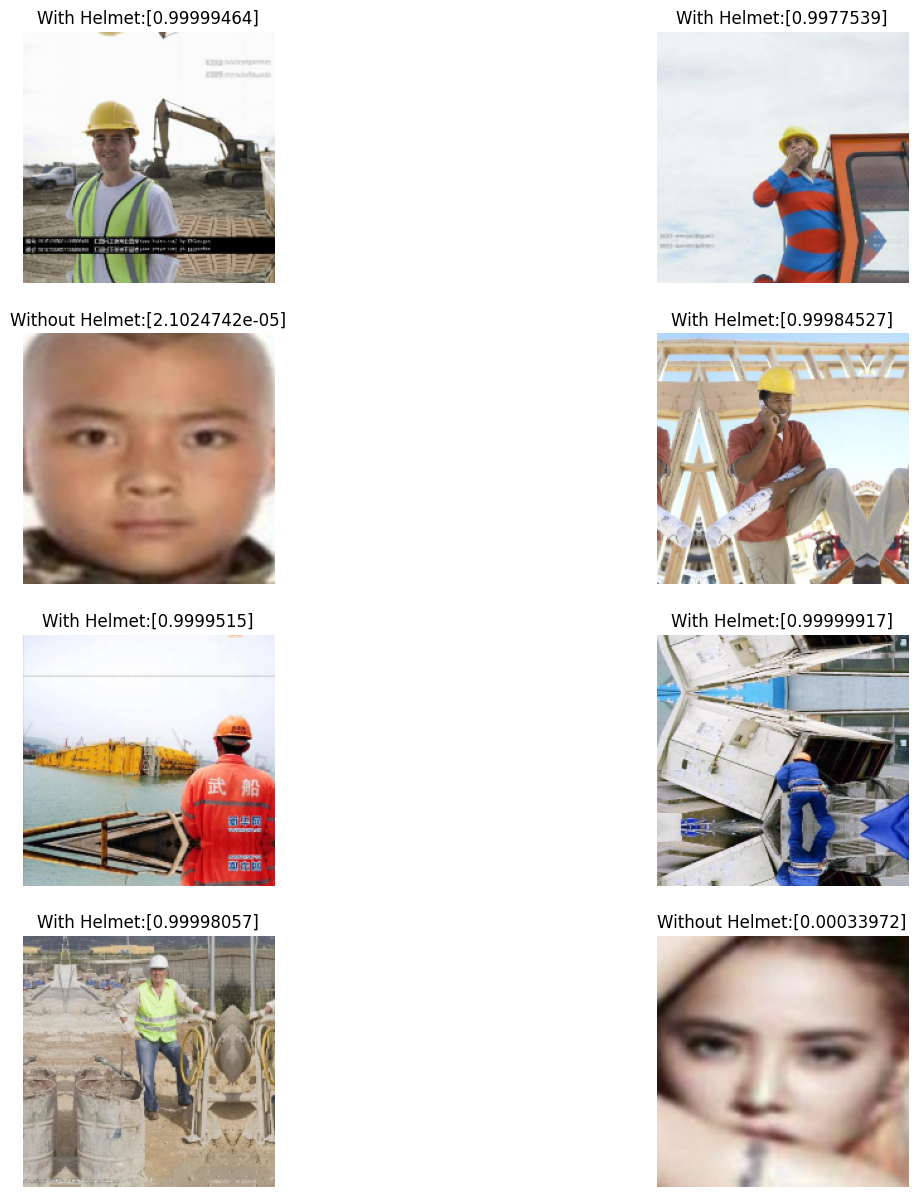

In [55]:
prev=m2.predict(xc_train_normalized)
f,ax=plt.subplots(4,2,figsize=(15,15))
for i,j in zip(ax.flatten(),range(8)):
  i.imshow(xc_train_normalized[j])
  i.axis('off')
  if prev[j]>0.5:
    i.set_title(f'With Helmet:{prev[j]}')
  else:
    i.set_title(f'Without Helmet:{prev[j]}')

### **Observations on model 2:**
- As we see the metrics(recall) and confusion matrix the score are too good which can also be overfitting.
- while The validation loss is slightly higher than training it is within limits as the curves are smooth and uniform.
- But, the Prediction visualisations are also correct maybe due to the data being small & clean.


## Model 3: (VGG-16 (Base + FFNN))

In [56]:
cls()

In [57]:
m3=Sequential()
m3.add(vgg16_m)
m3.add(Flatten())
m3.add(Dense(32, activation='relu'))
m3.add(BatchNormalization())
m3.add(Dropout(0.5))
m3.add(Dense(32, activation='relu'))
m3.add(BatchNormalization())
m3.add(Dropout(0.5))
m3.add(Dense(1, activation='sigmoid'))

In [58]:
opti=keras.optimizers.Adam(learning_rate=0.001)
m3.compile(optimizer=opti,loss='binary_crossentropy',metrics=['accuracy'])

In [59]:
h3=m3.fit(xc_train_normalized,yc_train,epochs=32,validation_data=(xc_val_normalized,yc_val),batch_size=32)

Epoch 1/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.7833 - loss: 0.5234 - val_accuracy: 0.7143 - val_loss: 0.4898
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9462 - loss: 0.1644 - val_accuracy: 0.8492 - val_loss: 0.2443
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9694 - loss: 0.1023 - val_accuracy: 0.9524 - val_loss: 0.1440
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9682 - loss: 0.0868 - val_accuracy: 1.0000 - val_loss: 0.0694
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9935 - loss: 0.0550 - val_accuracy: 1.0000 - val_loss: 0.0363
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9755 - loss: 0.0692 - val_accuracy: 1.0000 - val_loss: 0.0204
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9967 - loss: 0.0379 - val_accuracy: 1.0000 - val_loss: 0.0135
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9947 - loss: 0.0347 - val_accuracy: 1.0000 - 

In [60]:
m3tr=model_performance_classification(m3,xc_train_normalized,yc_train)
m3tr

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


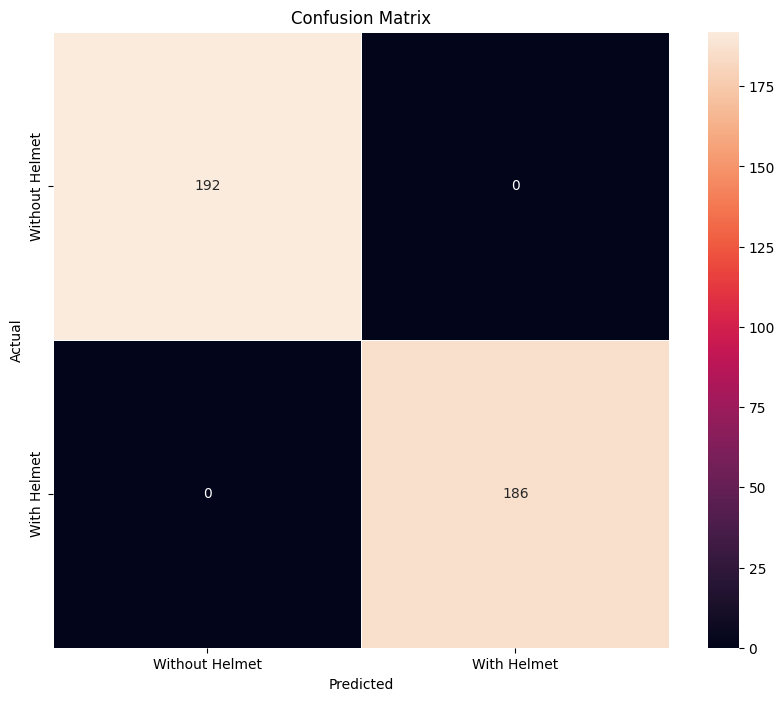

In [61]:
plot_confusion_matrix(m3,xc_train_normalized,yc_train)

In [62]:
m3vl=model_performance_classification(m3,xc_val_normalized,yc_val)
m3vl

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Accuracy    Recall  Precision  F1 Score
0  0.992063  0.992063   0.992189  0.992064

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


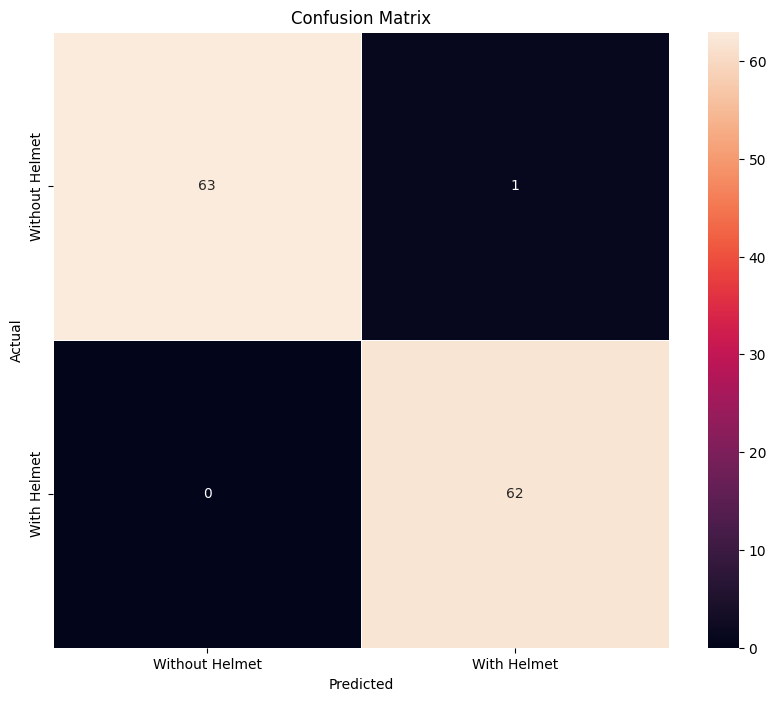

In [63]:

plot_confusion_matrix(m3,xc_val_normalized,yc_val)

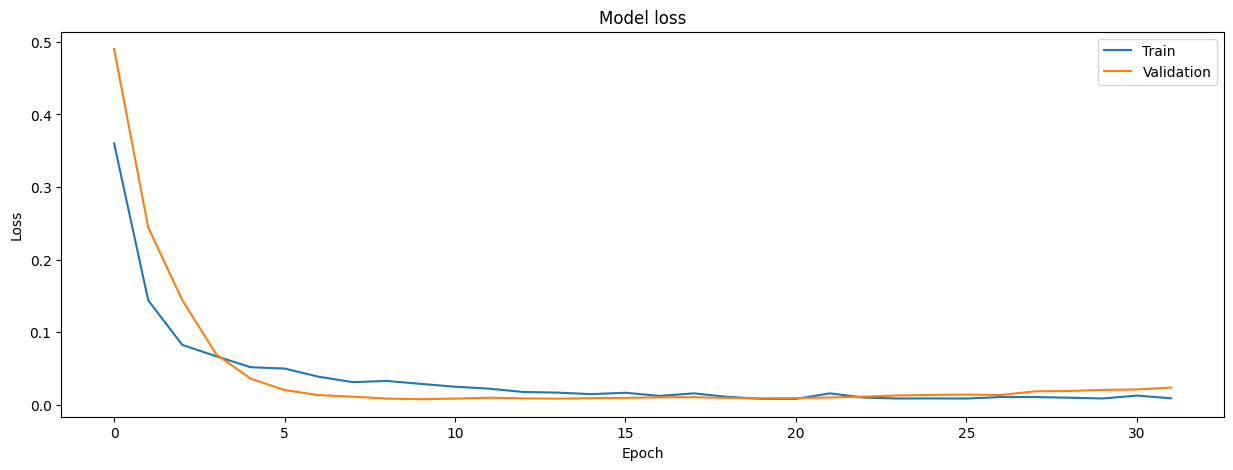

In [64]:
plot_history(h3)

#### Visualizing the predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


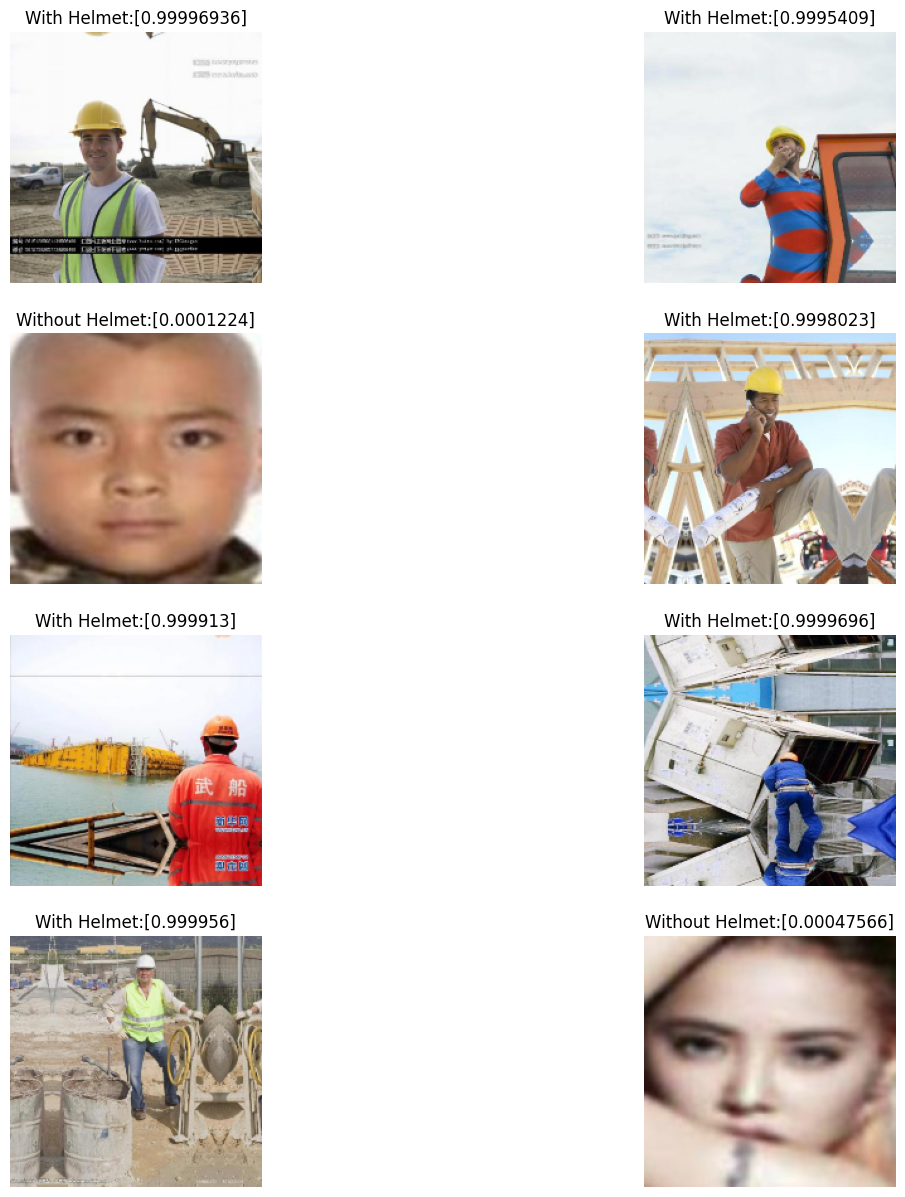

In [65]:
prev=m3.predict(xc_train_normalized)
f,ax=plt.subplots(4,2,figsize=(15,15))
for i,j in zip(ax.flatten(),range(8)):
  i.imshow(xc_train_normalized[j])
  i.axis('off')
  if prev[j]>0.5:
    i.set_title(f'With Helmet:{prev[j]}')
  else:
    i.set_title(f'Without Helmet:{prev[j]}')

### **Observations of model 3:**:
- The model also shows slight overfitting.
- The loss curves show slight oscillations when compared to **Model 2**, but there is convergence and the validation losses are smaller in this model.
- The Predicted values are becoming more concise in certain cases with metric evaluation being same as previous model.
- As the metrics(recall) and confusion matrix scores show model is doing really well may not be robust since the data being clean and small.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [66]:
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)


# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow(xc_train_normalized,yc_train,batch_size=21,shuffle=True)


In [67]:
cls()

In [68]:
m4=Sequential()
m4.add(vgg16_m)
m4.add(Flatten())
m4.add(Dense(32, activation='relu'))
m4.add(BatchNormalization())
m4.add(Dropout(0.5))
m4.add(Dense(32, activation='relu'))
m4.add(BatchNormalization())
m4.add(Dropout(0.5))
m4.add(Dense(1, activation='sigmoid'))

In [69]:
opti=keras.optimizers.Adam(learning_rate=0.001)
m4.compile(optimizer=opti,loss='binary_crossentropy',metrics=['accuracy'])

In [70]:
h4=m4.fit(train_generator,epochs=32,validation_data=(xc_val_normalized,yc_val),batch_size=32)

Epoch 1/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.8169 - loss: 0.3957 - val_accuracy: 0.9921 - val_loss: 0.0346
Epoch 2/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9439 - loss: 0.1486 - val_accuracy: 0.9921 - val_loss: 0.0224
Epoch 3/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9733 - loss: 0.1224 - val_accuracy: 1.0000 - val_loss: 0.0219
Epoch 4/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9717 - loss: 0.0839 - val_accuracy: 0.9921 - val_loss: 0.0138
Epoch 5/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9940 - loss: 0.0597 - val_accuracy: 0.9921 - val_loss: 0.0108
Epoch 6/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9953 - loss: 0.0551 - val_accuracy: 0.9921 - val_loss: 0.0203
Epoch 7/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.9893 - loss: 0.0416 - val_accuracy: 0.9921 - val_loss: 0.0216
Epoch 8/32
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9865 - loss: 0.0385 - val_accuracy: 0.

In [71]:
# Initialize empty lists to collect data
all_images = []
all_labels = []

# Iterate through the generator until all data is retrieved
for _ in range(len(train_generator)):
    imag, labela = next(train_generator)
    all_images.append(imag)
    all_labels.append(labela)

# Concatenate all batches into single arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(all_images.shape)  # Shape: (total_samples, height, width, channels)
print(all_labels.shape)  #

(378, 200, 200, 3)
(378,)


In [72]:
all_labels=pd.Series(all_labels)
all_labels

0      1
1      0
2      1
3      0
4      1
      ..
373    0
374    1
375    1
376    1
377    0
Length: 378, dtype: int64

In [73]:

m4tr=model_performance_classification(m4,all_images,all_labels)
m4tr

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


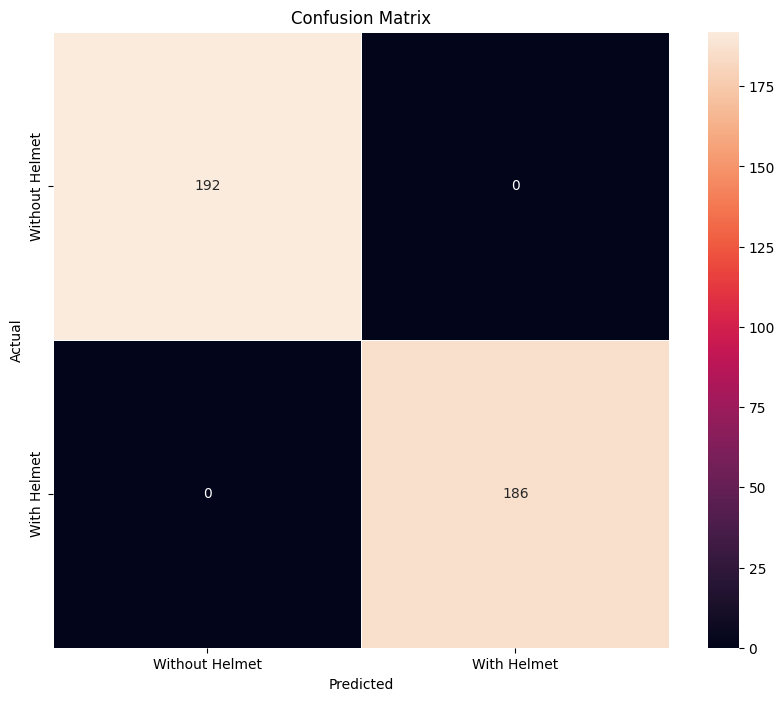

In [74]:
plot_confusion_matrix(m4,all_images,all_labels)

In [75]:
m4vl=model_performance_classification(m4,xc_val_normalized,yc_val)
m4vl

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Accuracy    Recall  Precision  F1 Score
0  0.992063  0.992063   0.992189  0.992064

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


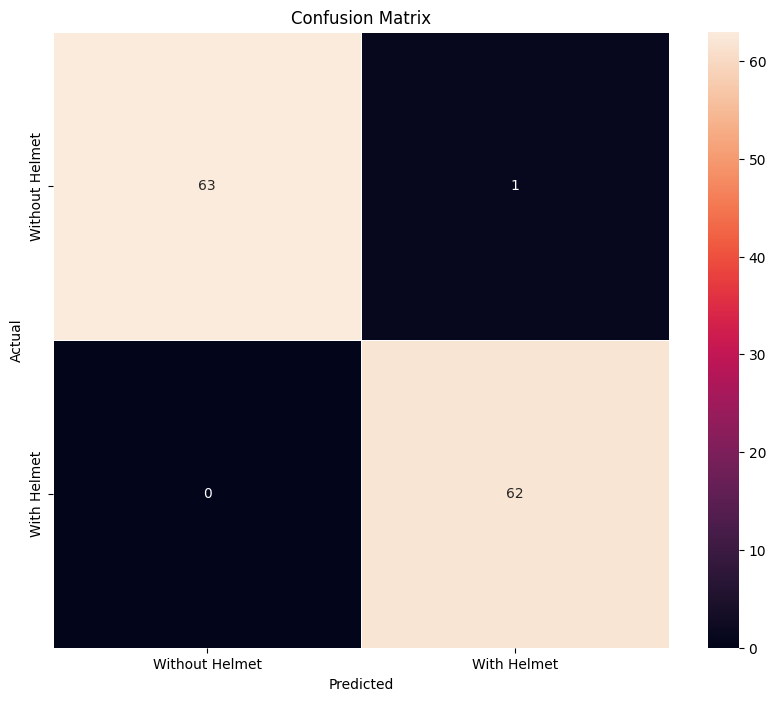

In [76]:
plot_confusion_matrix(m4,xc_val_normalized,yc_val)

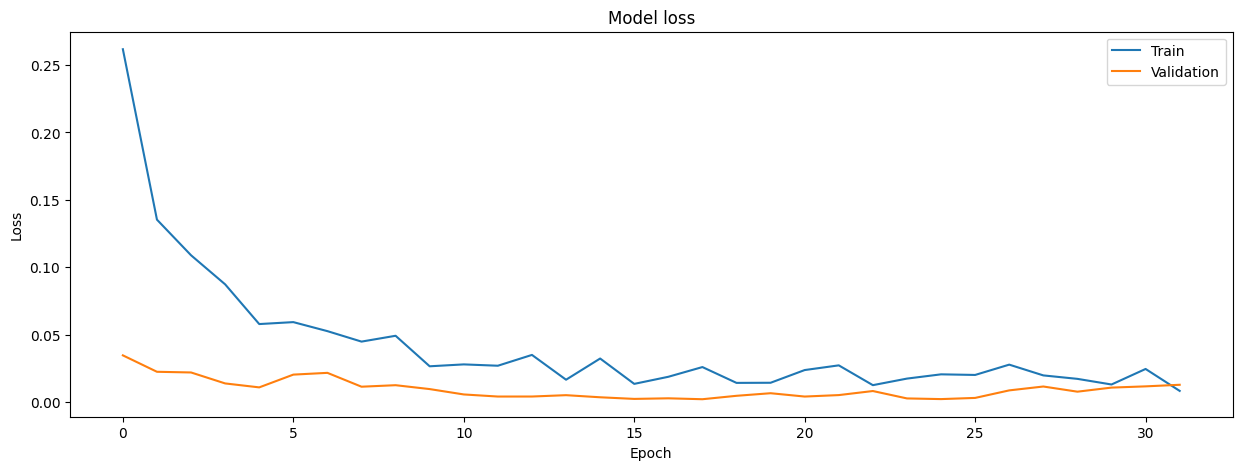

In [77]:
plot_history(h4)

#### Visualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


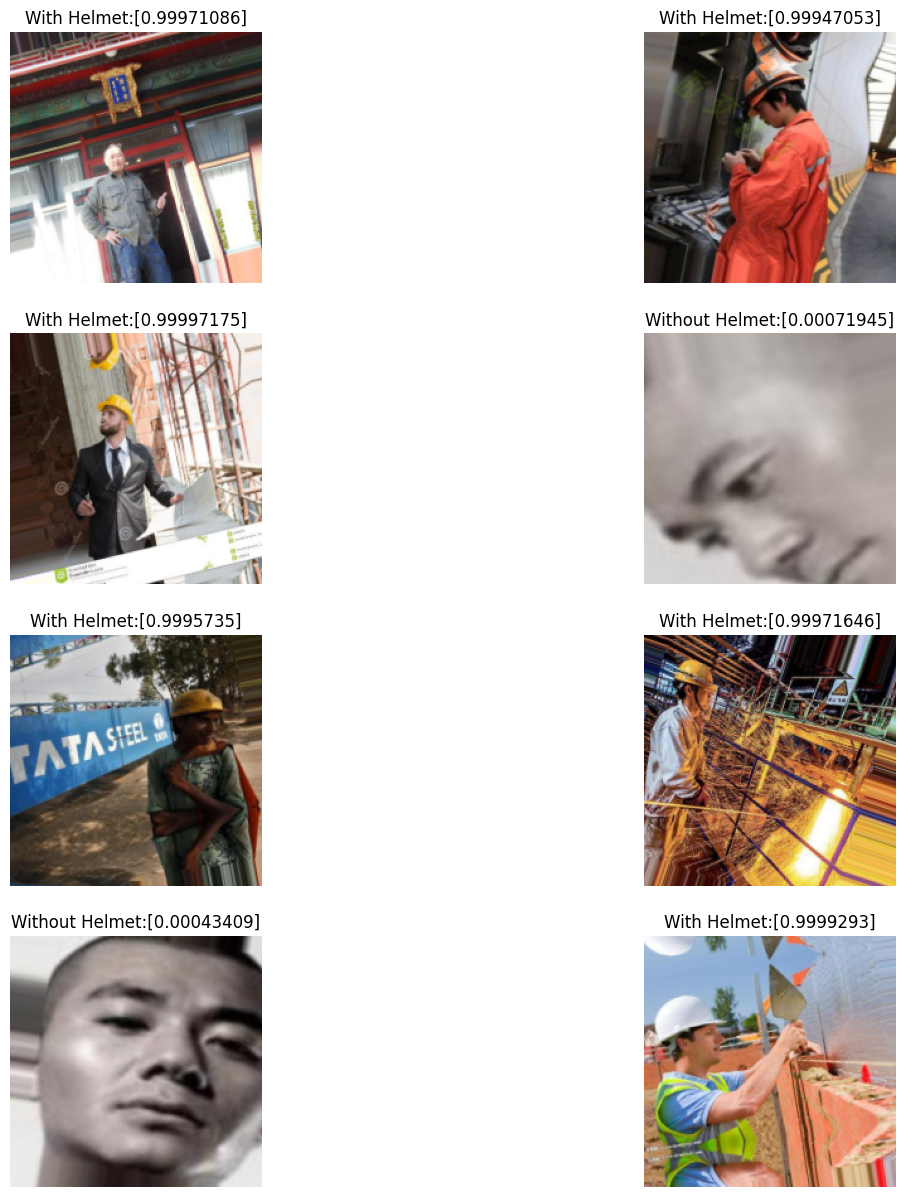

In [78]:

prev=m4.predict(imag)

f,ax=plt.subplots(4,2,figsize=(15,15))
for i,j in zip(ax.flatten(),range(8)):
  i.imshow(imag[j])
  i.axis('off')
  if prev[j]>0.5:
    i.set_title(f'With Helmet:{prev[j]}')
  else:
    i.set_title(f'Without Helmet:{prev[j]}')

### **Observations on model 4:**
- Although model may shows slight overfitting The metrics(recall) and matix shows the model is doing very well even with the augmented data which shows its robustness when compared to the previous models.
- The loss curves suggest that validation losses are more smaller than previous models.


# **Model Performance Comparison and Final Model Selection**

In [79]:
train_eval_result=pd.concat([m1tr.T,m2tr.T,m3tr.T,m4tr.T],axis=1)
train_eval_result.columns=['Model 1:Basic CNN','Model 2:Base VGG16','Model 3:VGG16+FNN','Model 4:VGG16+FNN+Data augmentation']
print("Models Results on Training data")
print("**"*50)
train_eval_result

Models Results on Training data
****************************************************************************************************


Model 1:Basic CNN  Model 2:Base VGG16  Model 3:VGG16+FNN  \
Accuracy            0.579365                 1.0                1.0   
Recall              0.579365                 1.0                1.0   
Precision           0.769909                 1.0                1.0   
F1 Score            0.483952                 1.0                1.0   

           Model 4:VGG16+FNN+Data augmentation  
Accuracy                                   1.0  
Recall                                     1.0  
Precision                                  1.0  
F1 Score                                   1.0

In [80]:
val_eval_result=pd.concat([m1vl.T,m2vl.T,m3vl.T,m4vl.T],axis=1)
val_eval_result.columns=train_eval_result.columns
print("Models Results on validation data")
print("**"*50)
val_eval_result

Models Results on validation data
****************************************************************************************************


Model 1:Basic CNN  Model 2:Base VGG16  Model 3:VGG16+FNN  \
Accuracy            0.611111                 1.0           0.992063   
Recall              0.611111                 1.0           0.992063   
Precision           0.779744                 1.0           0.992189   
F1 Score            0.537903                 1.0           0.992064   

           Model 4:VGG16+FNN+Data augmentation  
Accuracy                              0.992063  
Recall                                0.992063  
Precision                             0.992189  
F1 Score                              0.992064

### **Final Model Selection**

Based on the observations:

- As we observe model 1 metrics are not good and model is not able to classify people with helmets.
- The results of **models 2, 3, and 4** are identical in terms of performance metrics(recall).
- However, **Model 4** was trained using augmented data, which enhances its robustness to variations in the images.

#### **Conclusion**
**Model 4** is selected as the final model for deployment due to its ability to generalize better to unseen data.


## Test Performance

In [81]:
m4ts=model_performance_classification(m4,xc_test_normalized,yc_test)
m4ts

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

In [82]:
m4eval=pd.concat([m4tr.T,m4vl.T,m4ts.T],axis=1)
m4eval.columns=['Train','Validation','Test']
m4eval

Train  Validation  Test
Accuracy     1.0    0.992063   1.0
Recall       1.0    0.992063   1.0
Precision    1.0    0.992189   1.0
F1 Score     1.0    0.992064   1.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


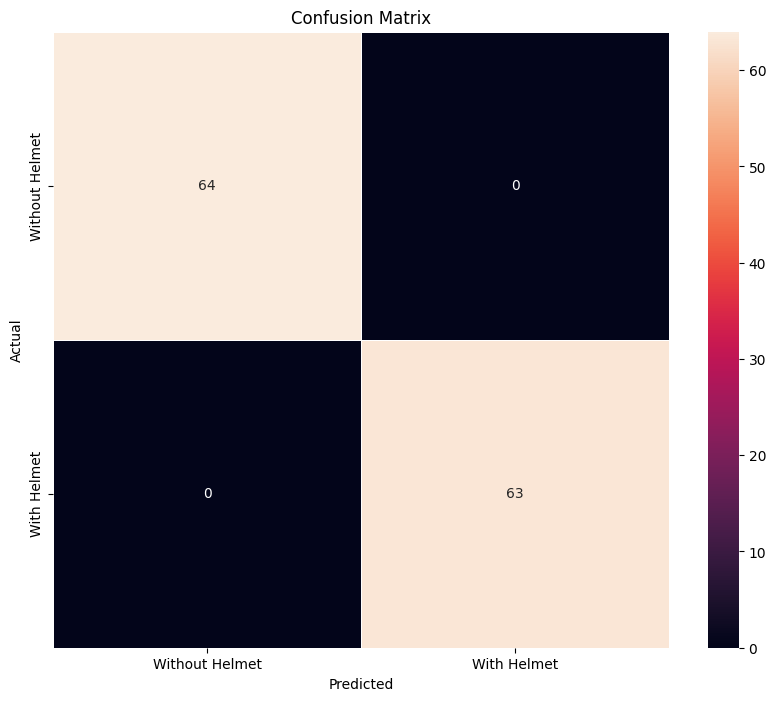

In [83]:
plot_confusion_matrix(m4,xc_test_normalized,yc_test)

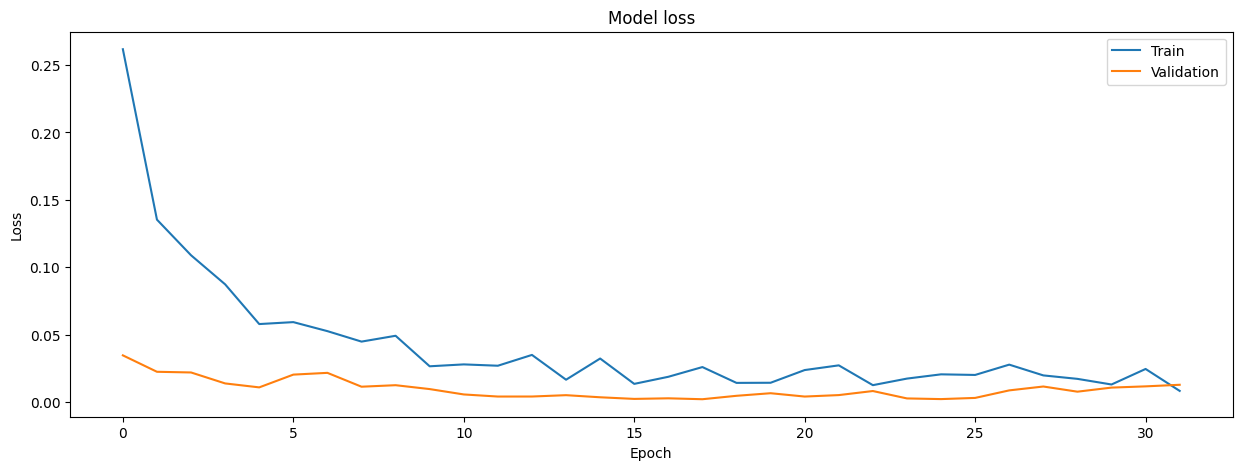

In [84]:
plot_history(h4)

In [85]:
print("Classification Report - Train data",end="\n\n")
crtr = classification_report(yc_train,m4.predict(xc_train_normalized)>0.5)
print(crtr)

Classification Report - Train data

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       192
           1       1.00      1.00      1.00       186

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378



In [86]:
print("Classification Report - Validation data",end="\n\n")
crvl = classification_report(yc_val,m4.predict(xc_val_normalized)>0.5)
print(crvl)

Classification Report - Validation data

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        64
           1       0.98      1.00      0.99        62

    accuracy                           0.99       126
   macro avg       0.99      0.99      0.99       126
weighted avg       0.99      0.99      0.99       126



In [87]:
print("Classification Report - Test data",end="\n\n")
crts = classification_report(yc_test,m4.predict(xc_test_normalized)>0.5)
print(crts)

Classification Report - Test data

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        63

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127



### **Observations on best model(model 4):**
- The reports, metrics(recall) and matrix as well loss curves all suggest very good performance.
- Since the model is trained on augmented data it is robust and able learn the right elements excluding the noise.

**Actionable Insights and Recommendations**

**Key Insights**

Model Performance: The final model (VGG16 + FFNN + Data Augmentation) achieves high accuracy, recall, and precision on both training and validation sets, indicating strong performance in distinguishing between workers with and without helmets.

Recall Priority: Emphasis on recall for the "Without Helmet" class is appropriate, as missing non-compliance cases poses the greatest safety risk.

Data Augmentation: Incorporating data augmentation has improved the model’s robustness, making it better suited for real-world deployment where image conditions vary.

Potential Overfitting: Despite strong results, the consistently high metrics across all splits and small dataset size suggest a risk of overfitting. This may limit generalizability to new, unseen environments.

**Recommendations**

1. Expand and Diversify the Dataset
Collect more images from varied environments, lighting conditions, and worker activities to improve the model’s generalization and reduce overfitting risk.

Include challenging cases such as occlusions, different helmet types, and crowded scenes.

2. Enhance Model Robustness
Continue using data augmentation techniques (flipping, rotation, scaling, color jitter) to simulate real-world variability.

Consider integrating attention mechanisms (e.g., CBAM, GAM, Coordinate Attention) to help the model focus on relevant features, especially in complex backgrounds.

3. Optimize for Real-Time Deployment
Evaluate model inference speed and optimize for deployment on edge devices if needed (e.g., pruning, quantization, or using lightweight architectures).

Test the model in real-time conditions to ensure latency meets operational requirements.

4. Monitor and Maintain Model Performance
Implement a monitoring system to track model performance and flag significant drops in accuracy or recall over time.

Set up processes for periodic retraining with new data to address model drift and maintain high performance.

5. Address Ethical and Operational Concerns
Ensure privacy by processing images on-device or using privacy-preserving techniques where feasible.

Develop clear user interfaces and alert systems for safety officers to act promptly on detection results.

Provide training and documentation for staff to understand and use the system effectively.

6. Future Enhancements
Explore advanced detection models such as YOLOv8 or improved YOLOv5 variants, which have demonstrated superior speed and accuracy in helmet detection tasks.

Consider multi-class detection (e.g., detecting different PPE types) for broader safety compliance monitoring